# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [406]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


In [408]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [410]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [413]:


# 1. Check data types of each column
print(" Data types of each column:\n")
print(df.dtypes)

# 2. Check for standard missing values (NaN)
print("\n Count of missing (NaN) values per column:\n")
print(df.isnull().sum())

# 3. Check for 'unknown' values in categorical columns
print("\n Count of 'unknown' values in each column (if any):\n")
for col in df.columns:
    if df[col].dtype == 'object':  # likely categorical
        unknown_count = (df[col] == 'unknown').sum()
        if unknown_count > 0:
            print(f"{col}: {unknown_count}")

# 4. Optional: Display unique values for a few selected columns (categorical overview)
print("\n Sample unique values for selected columns:")
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
    print(f"\n{col}:")
    print(df[col].unique())


 Data types of each column:

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

 Count of missing (NaN) values per column:

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribo

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [416]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 4: Understanding the Task

**Business Objective:**

The objective of this analysis is to build a predictive model that can identify which clients are most likely to subscribe to a term deposit based on their personal, contact, campaign, and socio-economic attributes. 

This enables the bank to:
- Increase the efficiency of its direct marketing campaigns,
- Reduce the number of unsuccessful contact attempts,
- Focus resources on high-potential customers,
- Improve overall campaign conversion rates.

**Machine Learning Task:**

This is a **binary classification** problem where the target variable is:
- `y`: whether the client subscribed to a term deposit (`yes` or `no`)

We aim to train, evaluate, and compare several classification algorithms (e.g., Logistic Regression, Decision Tree, K-Nearest Neighbors, and Support Vector Machine) using appropriate evaluation metrics like **accuracy**, **precision**, **recall**, **F1-score** to determine which model best meets the business needs.


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

**Features to Use:**  
We'll include only these **bank client information** features:

- `age`
- `job`
- `marital`
- `education`
- `default`
- `housing`
- `loan`

**Target Variable:**

- `y` – whether the client subscribed to a term deposit  
  (convert `"yes"` to `1`, `"no"` to `0`)


 Feature matrix shape: (28831, 28)
 Target distribution in training set:
y
0    0.887343
1    0.112657
Name: proportion, dtype: float64


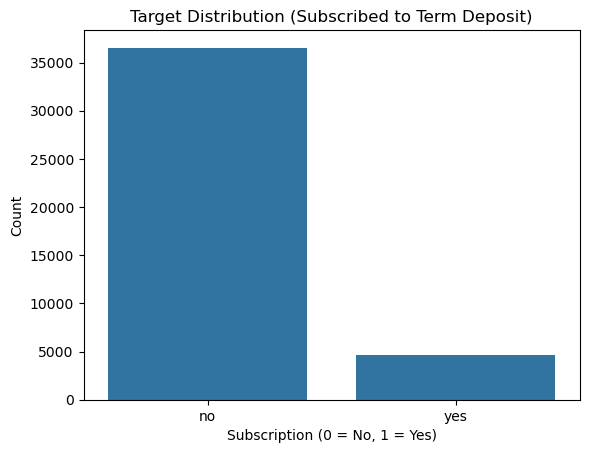

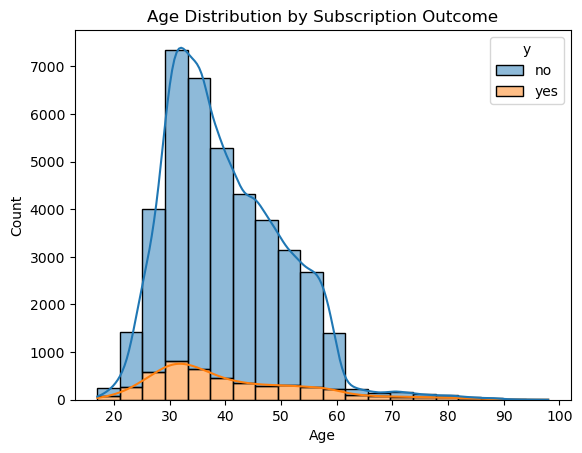

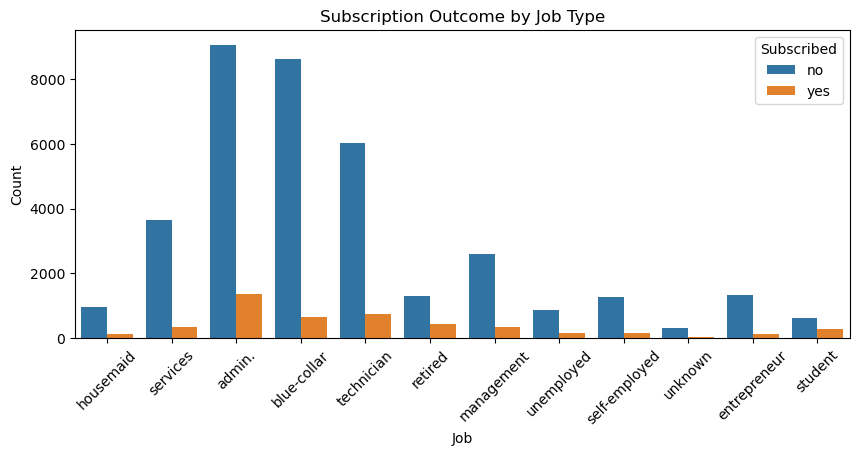

In [422]:
# Select only bank client features
bank_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
target = 'y'

# Extract X and y
X = df[bank_features]
y = df[target].map({'yes': 1, 'no': 0})  # binary target

# Identify categorical columns for one-hot encoding
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create a ColumnTransformer for encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # leave numeric features as-is
)

# Apply transformations
X_prepared = preprocessor.fit_transform(X)

# Optional: get feature names after encoding
ohe = preprocessor.named_transformers_['cat']
encoded_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = list(encoded_feature_names) + numeric_cols

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.3, random_state=42, stratify=y
)

print(f" Feature matrix shape: {X_train.shape}")
print(f" Target distribution in training set:\n{y_train.value_counts(normalize=True)}")

# Check class balance of target variable
sns.countplot(x='y', data=df)
plt.title("Target Distribution (Subscribed to Term Deposit)")
plt.xlabel("Subscription (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Visualize age distribution
sns.histplot(data=df, x='age', bins=20, hue='y', kde=True, multiple='stack')
plt.title("Age Distribution by Subscription Outcome")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Job vs subscription (categorical)
plt.figure(figsize=(10,4))
sns.countplot(x='job', data=df, hue='y')
plt.xticks(rotation=45)
plt.title("Subscription Outcome by Job Type")
plt.xlabel("Job")
plt.ylabel("Count")
plt.legend(title='Subscribed')
plt.show()

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.


Now that the features and target variable are prepared, we will split the dataset into training and testing sets.

- The **training set** (70% of the data) will be used to train the machine learning models.
- The **test set** (30% of the data) will be used to evaluate model performance on unseen data.
- We'll use **stratified sampling** to ensure the target variable (`y`) maintains the same class distribution in both sets.


 X_train shape: (28831, 28)
 X_test shape: (12357, 28)

Target distribution in training set:
y
0    0.887343
1    0.112657
Name: proportion, dtype: float64

Target distribution in test set:
y
0    0.887351
1    0.112649
Name: proportion, dtype: float64


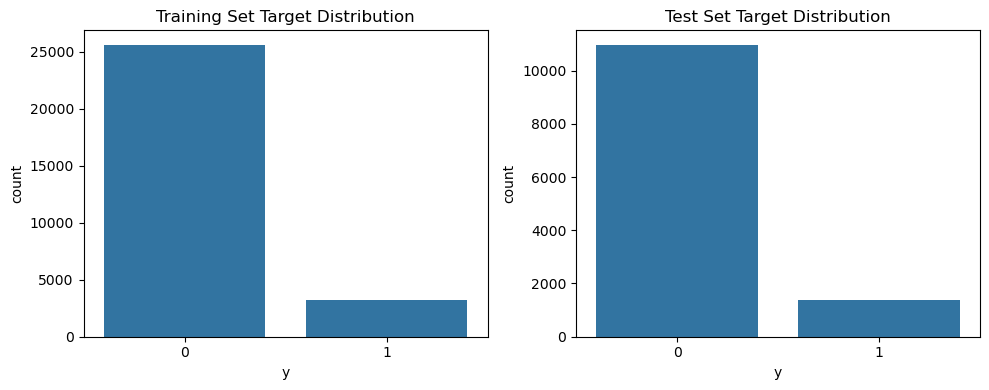

In [428]:


# Split the data into train and test sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.3, random_state=42, stratify=y
)

# Confirm the shape and class balance
print(f" X_train shape: {X_train.shape}")
print(f" X_test shape: {X_test.shape}")
print(f"\nTarget distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"\nTarget distribution in test set:\n{y_test.value_counts(normalize=True)}")
# Check that stratification maintained class balance
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Training Set Target Distribution")
axes[0].set_xlabel("y")

sns.countplot(x=y_test, ax=axes[1])
axes[1].set_title("Test Set Target Distribution")
axes[1].set_xlabel("y")

plt.tight_layout()
plt.show()


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?



In classification problems, a common baseline is the **majority class predictor** — a model that always predicts the most frequent class in the training data.

Since our target variable `y` is binary (1 = subscribed, 0 = not subscribed), the baseline will be:
- Always predict **"no"** (0), if that is the majority class.

We will calculate the **accuracy, precision, recall, and F1-score** for this dummy classifier so that our future models can be compared against it.


In [433]:


# Create and train a baseline (dummy) model that always predicts the majority class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

# Predict on test set
y_pred_dummy = dummy_clf.predict(X_test)

# Evaluate baseline performance
print(" Baseline Model Performance (Majority Class Classifier):")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_dummy):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_dummy):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_dummy):.4f}")


 Baseline Model Performance (Majority Class Classifier):
Accuracy:  0.8874
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  


For our first real model, we will use **Logistic Regression**, a widely used and interpretable classification algorithm. It works well as a baseline machine learning model for binary classification tasks.


 Logistic Regression Performance:
Accuracy:  0.8874
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000


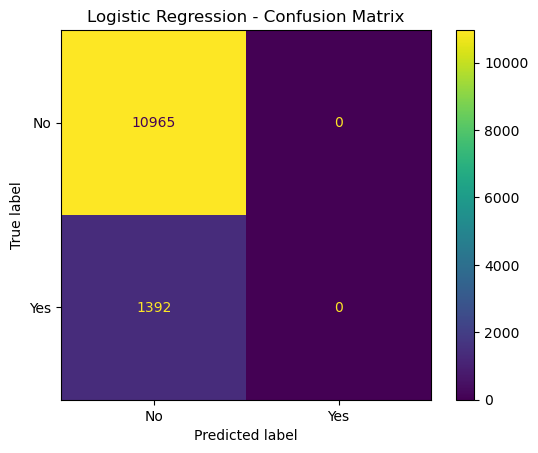

In [438]:


# Build and train the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Make predictions
y_pred_logreg = logreg.predict(X_test)

# Evaluate the model
print(" Logistic Regression Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_logreg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_logreg, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_logreg, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_logreg, zero_division=0):.4f}")

# Confusion Matrix for Logistic Regression
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test, display_labels=["No", "Yes"])
plt.title("Logistic Regression - Confusion Matrix")
plt.show()



### Problem 9: Score the Model

What is the accuracy of your model?

 Logistic Regression Accuracy on Test Set: 0.8874


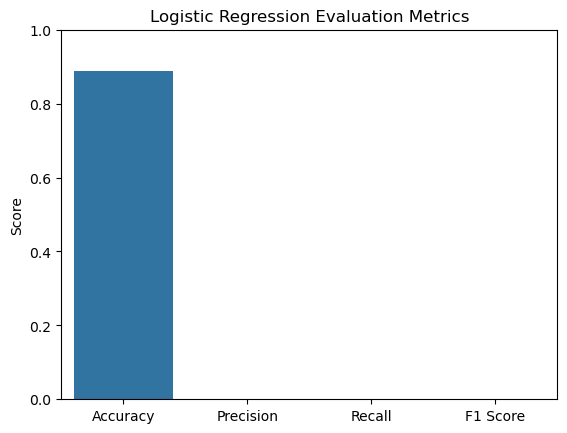

In [440]:

# Print only the accuracy of the logistic regression model
accuracy = accuracy_score(y_test, y_pred_logreg)
print(f" Logistic Regression Accuracy on Test Set: {accuracy:.4f}")
# Bar chart of scores for logistic regression
scores = {
    'Accuracy': accuracy_score(y_test, y_pred_logreg),
    'Precision': precision_score(y_test, y_pred_logreg, zero_division=0),
    'Recall': recall_score(y_test, y_pred_logreg, zero_division=0),
    'F1 Score': f1_score(y_test, y_pred_logreg, zero_division=0)
}

sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.ylim(0, 1)
plt.title("Logistic Regression Evaluation Metrics")
plt.ylabel("Score")
plt.show()


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

 Model Comparison:


,Model,Train Time (s),Train Accuracy,Test Accuracy
0,Logistic Regression,0.4106,0.8873,0.8874
1,K-Nearest Neighbors,0.0010,0.8910,0.8753
2,Decision Tree,0.3629,0.9188,0.8640
3,Support Vector Machine,8.1051,0.8873,0.8874


C:\Users\ylanj\AppData\Local\Temp\ipykernel_32476\2861767620.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x='Model', y='Test Accuracy', palette='Blues_d')


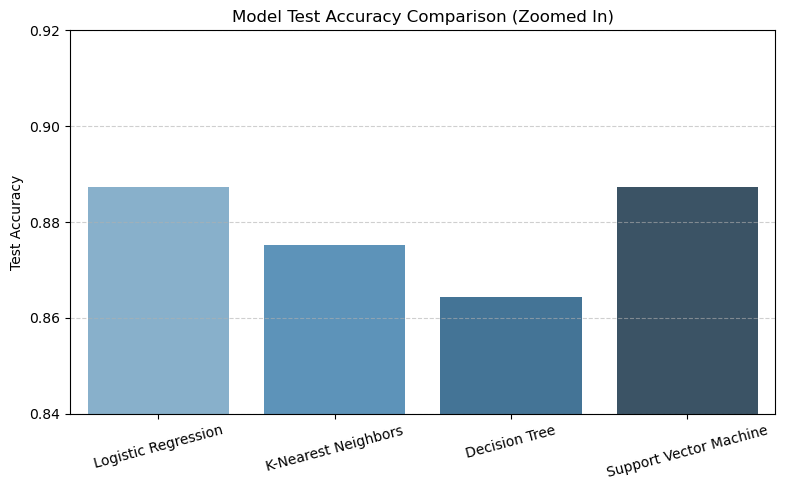

In [444]:

# List of models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC()
}

results = []

# Loop through each model
for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    train_time = round(end - start, 4)

    results.append({
        'Model': name,
        'Train Time (s)': train_time,
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(" Model Comparison:")
display(results_df)



# Compare default models
model_comparisons = []
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC()
}

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    duration = end - start

    model_comparisons.append({
        'Model': name,
        'Train Time (s)': duration,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc
    })

comparison_df = pd.DataFrame(model_comparisons)


# Create a barplot of test accuracy with better Y-axis intervals
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x='Model', y='Test Accuracy', palette='Blues_d')

# Improve Y-axis visibility
plt.ylim(0.84, 0.92)
plt.yticks([0.84, 0.86, 0.88, 0.90, 0.92])
plt.title("Model Test Accuracy Comparison (Zoomed In)")
plt.ylabel("Test Accuracy")
plt.xlabel("")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric


We now aim to improve our classification models. This includes:

1. **Feature Engineering and Exploration**: Evaluating which features should be included or dropped.
   - For example, if we had a `gender` feature, we’d consider:
     - Gender might be helpful but might lead to some level of **Gender Bias**.
   - In our dataset, we’ll expand our features to include variables like `campaign`, `pdays`, `previous`, `poutcome`, and `euribor3m`.

2. **Hyperparameter Tuning**: We'll tune a Decision Tree model using GridSearchCV to find the best values for:
   - `max_depth`
   - `min_samples_leaf`
   - `criterion`

3. **Improved Evaluation**: Since the dataset is imbalanced, we’ll use:
   - Precision
   - Recall
   - F1-score  
   These give better insights than accuracy alone.


 Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 5}
 Accuracy:  0.8753
 Precision: 0.4177
 Recall:    0.2716
 F1 Score:  0.3291

 Full Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     10965
           1       0.42      0.27      0.33      1392

    accuracy                           0.88     12357
   macro avg       0.66      0.61      0.63     12357
weighted avg       0.86      0.88      0.86     12357



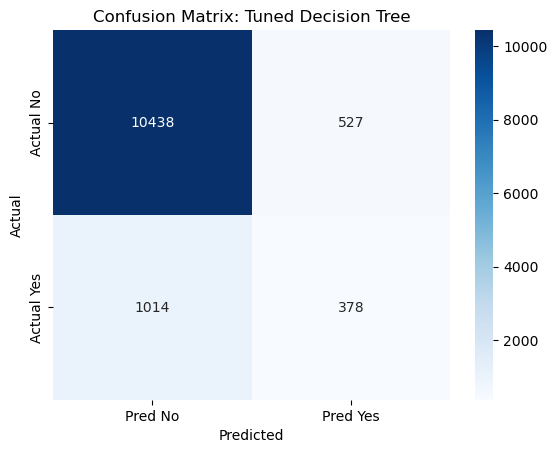

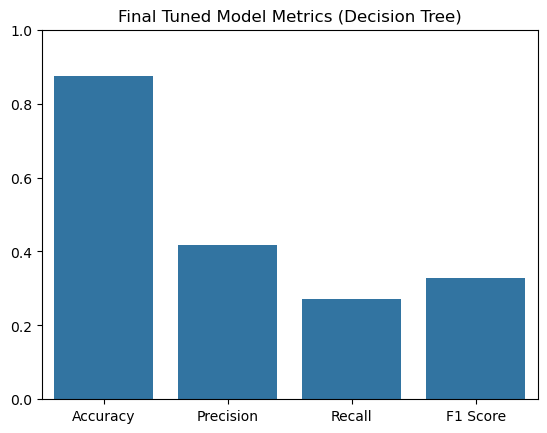

In [402]:

# Target encoding
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# --- 1. Feature Engineering and Exploration ---
# Including more predictive features
features = [
    'age', 'job', 'marital', 'education', 'housing', 'loan',
    'campaign', 'pdays', 'previous', 'poutcome', 'euribor3m'
]
X = df[features]
y = df['y']

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# --- Preprocessing Pipeline ---
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

# --- 2. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 3. Hyperparameter Tuning with GridSearchCV (Decision Tree) ---
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from Grid Search
best_model = grid_search.best_estimator_

# --- 4. Evaluation Metrics ---
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
report = classification_report(y_test, y_pred, zero_division=0)

# Show results
print(" Best Hyperparameters:", grid_search.best_params_)
print(f" Accuracy:  {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1 Score:  {f1:.4f}")
print("\n Full Classification Report:\n", report)
# Heatmap for confusion matrix of best model


conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred No", "Pred Yes"],
            yticklabels=["Actual No", "Actual Yes"])
plt.title("Confusion Matrix: Tuned Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Barplot of final model scores
final_scores = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

sns.barplot(x=list(final_scores.keys()), y=list(final_scores.values()))
plt.title("Final Tuned Model Metrics (Decision Tree)")
plt.ylim(0, 1)
plt.show()


##### Questions